# Natural Language Processing with Disaster Tweets

In [92]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

In [93]:
train = pd.read_csv(f"data/train.csv")
test = pd.read_csv(f"data/test.csv")

In [94]:
train.head().T

,0,1,2,3,4
id,1,4,5,6,7
keyword,NaN,NaN,NaN,NaN,NaN
location,NaN,NaN,NaN,NaN,NaN
text,Our Deeds are the Reason of this #earthquake M...,Forest fire near La Ronge Sask. Canada,All residents asked to 'shelter in place' are ...,"13,000 people receive #wildfires evacuation or...",Just got sent this photo from Ruby #Alaska as ...
target,1,1,1,1,1


## Exploratory data analysis

Handling missing values

When inplace = True , the data is modified in place, which means it will return nothing and the dataframe is now updated. When inplace = False , which is the default, then the operation is performed and it returns a copy of the object. You then need to save it to something

In [95]:
train.fillna(1, inplace=True)
test.fillna(1, inplace=True)

In [96]:
train.keyword.value_counts()[:5]

1             61
fatalities    45
deluge        42
armageddon    42
harm          41
Name: keyword, dtype: int64

distribution of the target variable

In [97]:
disasters = train[train.target == 1].shape[0] #number of post with target as disaster shape[0] number of row 
non_disasters = train[train.target == 0].shape[0]#number of post with target as non-disaster

train.Id is a pandas Series and is one dimensional. train is a pandas DataFrame and is two dimensional. shape is an attribute that both DataFrames and Series have. It is always a tuple. For a Series the tuple has only only value (x,). For a DataFrame shape is a tuple with two values (x, y). So train.Id.shape[0] would also return 1467. However, train.Id.shape[1] would produce an error while train.shape[1] would give you the number of columns in train.

Furthermore, pandas Panel objects are three dimensional and shape for it returns a tuple (x, y, z)

In [98]:
disasters

3271

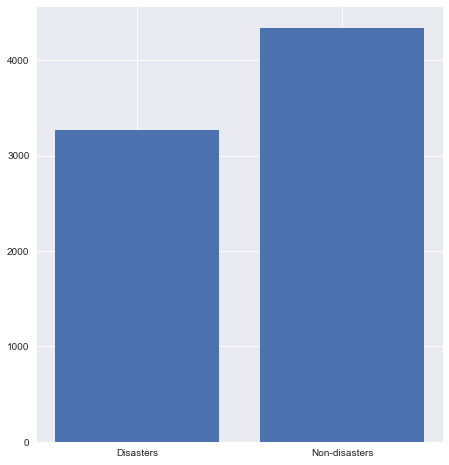

In [99]:
plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)#((nrows, ncols, fig index))
_ = plt.bar(["Disasters", "Non-disasters"], [disasters, non_disasters])

In [100]:
def plot_target_based_features(feature):
    x1 = train[train.target == 1][feature]
    x2 = train[train.target == 0][feature]
    plt.figure(1, figsize=(16, 8))
    plt.subplot(1, 1, 1)
    _ = plt.hist(x2, alpha=0.5, color="grey", bins=50)
    txt1 = "target variable categories distribution for feature {fe}".format(fe=feature)
    plt.title(label=txt1, 
          loc="center",
          fontsize=40, 
          color="green") 
    _ = plt.hist(x1, alpha=0.7, color="red", bins=50)

    return _

In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


creating anoter colunm in our trianset named text_len for checking the number of characters in the text feature

In [102]:
train["text_len"] = train.text.map(lambda x: len(x))

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   text_len  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


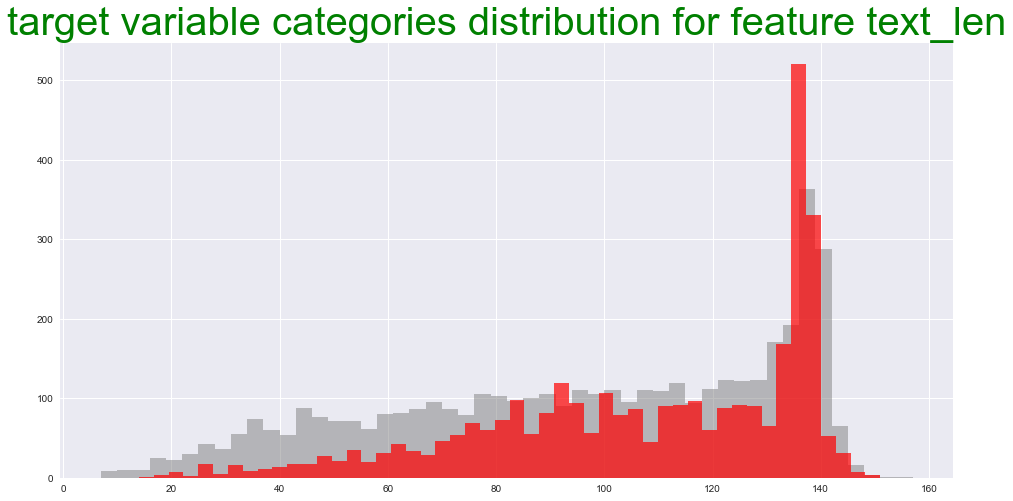

In [104]:
_ = plot_target_based_features("text_len")


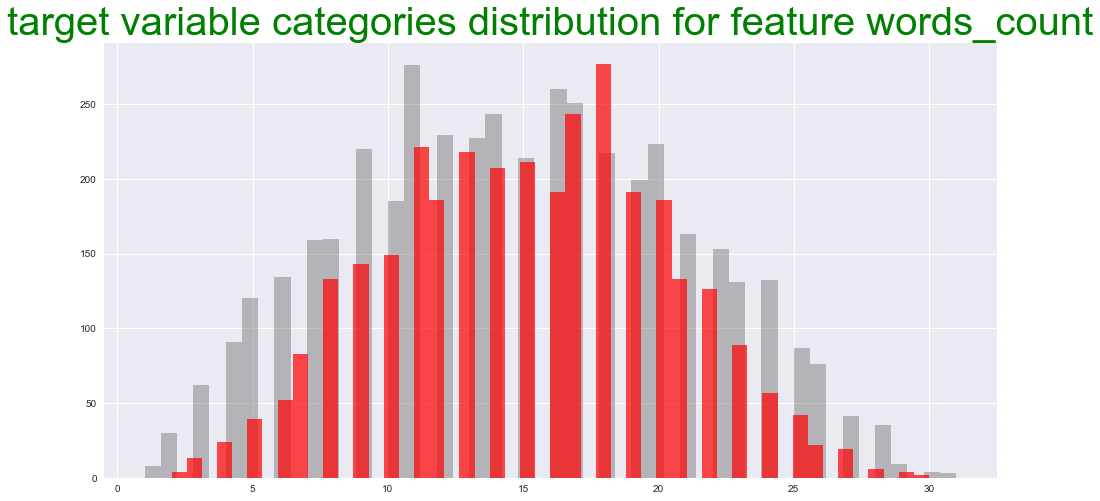

In [105]:
train["words_count"] = train.text.str.split().map(lambda x: len(x))
_ = plot_target_based_features("words_count")

Count the number of unique words

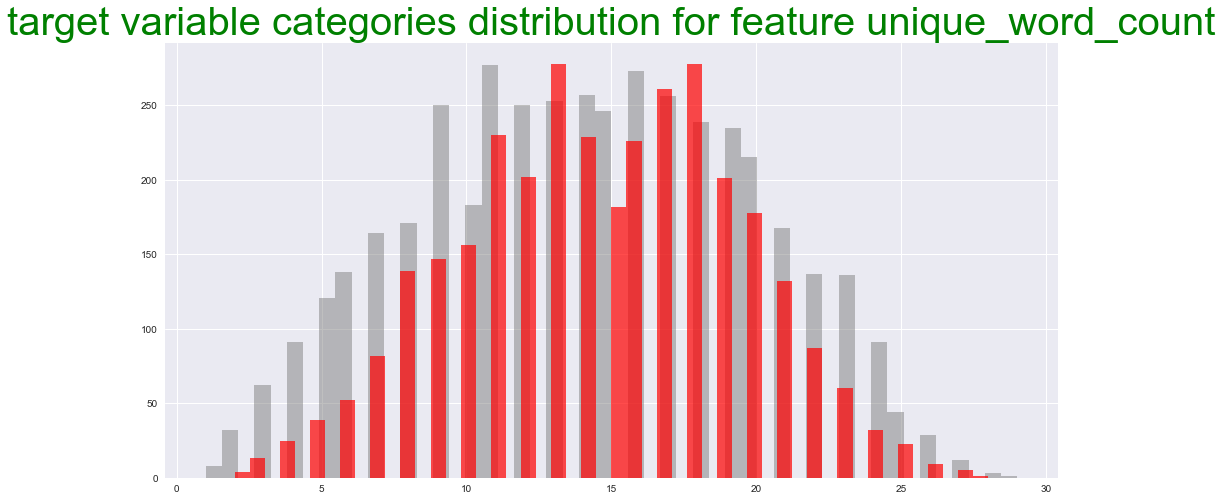

In [106]:
train["unique_word_count"] = train.text.map(lambda x: len(set(str(x).split())))
_ = plot_target_based_features("unique_word_count")

Punctuation count

In [107]:
import string

train["punctuation_count"] = train["text"].map(
    lambda x: len([c for c in str(x) if c in string.punctuation])
)

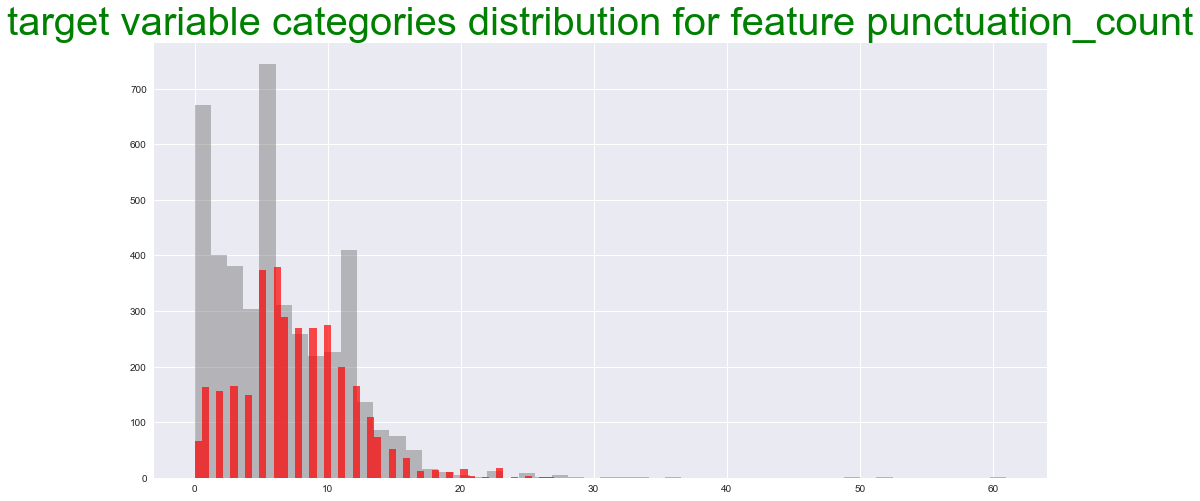

In [108]:
_ = plot_target_based_features("punctuation_count")

looking at these Plots one thing that we can tell is our target variable categories have very different distributions that are good news from Ml Models perspective,

In [109]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## N-gram analysis

In [110]:
from nltk.corpus import stopwords

def generate_ngrams(text, n_gram=1, stop=True):
    """
    Simple n-gram generator.
    """
    stop = set(stopwords.words("english")) if stop else {} #if stop is true then set stop ptherwise ignore it

    token = [
        token for token in text.lower().split(" ") if token != "" if token not in stop
    ]
    z = zip(*[token[i:] for i in range(n_gram)])
    ngrams = [" ".join(ngram) for ngram in z]

    return ngrams

In [111]:
from collections import defaultdict

In our case when a new word is encountered and is missing from the mapping, the default_factory function calls int() to supply a default count of zero and then, the increment operation builds up the count.

In [112]:
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

In [113]:
import nltk
nltk.download('stopwords')
for text in train[train.target == 1].text:
    for word in generate_ngrams(text):
        disaster_unigrams[word] += 1

for text in train[train.target == 0].text:
    for word in generate_ngrams(text):
        nondisaster_unigrams[word] += 1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
disaster_unigrams

In [116]:
df_disaster_unigrams = pd.DataFrame(
    sorted(disaster_unigrams.items(), key=lambda x: x[1], reverse=True)
)
df_nondisaster_unigrams = pd.DataFrame(
    sorted(nondisaster_unigrams.items(), key=lambda x: x[1], reverse=True)
)

In [ ]:
disaster_unigrams.items()

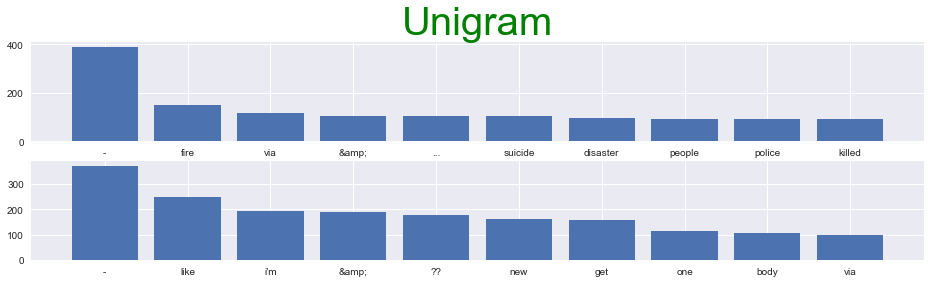

In [117]:
d1 = df_disaster_unigrams[0][:10]
d2 = df_disaster_unigrams[1][:10]

nd1 = df_nondisaster_unigrams[0][:10]
nd2 = df_nondisaster_unigrams[1][:10]


plt.figure(1, figsize=(16, 4))
plt.subplot(2, 1, 1)
_ = plt.bar(d1, d2)

plt.title(label="Unigram", 
          loc="center",
          fontsize=40, 
          color="green") 

plt.subplot(2, 1, 2)
_ = plt.bar(nd1, nd2)



In [118]:
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for text in train[train.target == 1].text:
    for word in generate_ngrams(text, n_gram=2):
        disaster_bigrams[word] += 1

for text in train[train.target == 0].text:
    for word in generate_ngrams(text, n_gram=2):
        nondisaster_bigrams[word] += 1

df_disaster_bigrams = pd.DataFrame(
    sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1]
)
df_nondisaster_bigrams = pd.DataFrame(
    sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1]
)

C:\Users\Hamza\anaconda3\envs\PY37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hamza\anaconda3\envs\PY37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


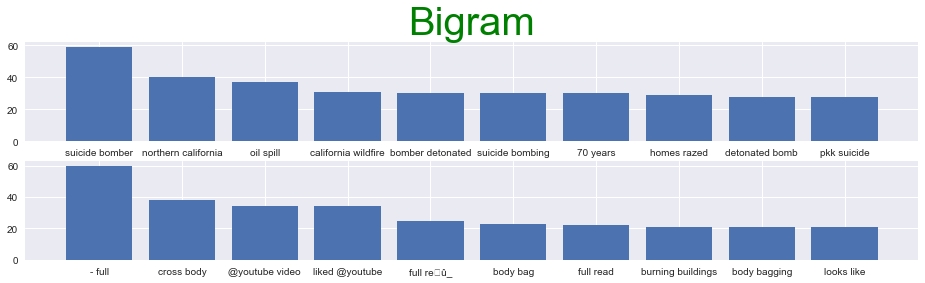

In [119]:
d1 = df_disaster_bigrams[0][:10]
d2 = df_disaster_bigrams[1][:10]

nd1 = df_nondisaster_bigrams[0][:10]
nd2 = df_nondisaster_bigrams[1][:10]

plt.figure(1, figsize=(16, 4))
plt.subplot(2, 1, 1)
_ = plt.bar(d1, d2)

plt.title(label="Bigram", 
          loc="center",
          fontsize=40, 
          color="green") 

plt.subplot(2, 1, 2)
_ = plt.bar(nd1, nd2)

In [120]:
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for text in train[train.target == 1].text:
    for word in generate_ngrams(text, n_gram=3):
        disaster_bigrams[word] += 1

for text in train[train.target == 0].text:
    for word in generate_ngrams(text, n_gram=3):
        nondisaster_bigrams[word] += 1

df_disaster_bigrams = pd.DataFrame(
    sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1]
)
df_nondisaster_bigrams = pd.DataFrame(
    sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1]
)

C:\Users\Hamza\anaconda3\envs\PY37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hamza\anaconda3\envs\PY37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


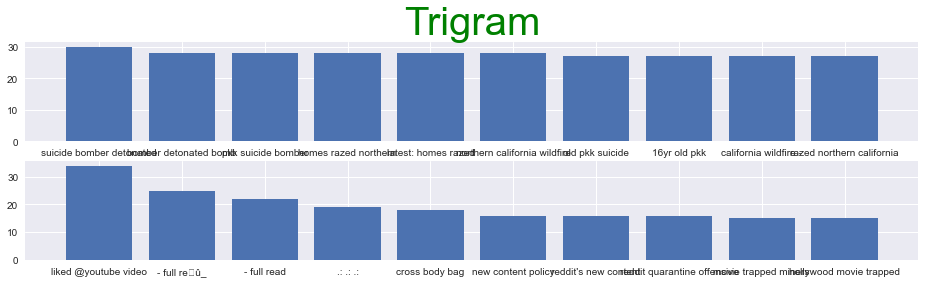

In [121]:
d1 = df_disaster_bigrams[0][:10]
d2 = df_disaster_bigrams[1][:10]

nd1 = df_nondisaster_bigrams[0][:10]
nd2 = df_nondisaster_bigrams[1][:10]

plt.figure(1, figsize=(16, 4))
plt.subplot(2, 1, 1)
_ = plt.bar(d1, d2)

plt.title(label="Trigram", 
          loc="center",
          fontsize=40, 
          color="green") 

plt.subplot(2, 1, 2)
_ = plt.bar(nd1, nd2)

we've divided our corpus-based into target variable categories and got the desired result as most of the N-gram of one category was missing from the other now let's check the most common bigrams in a whole corpus.

In [122]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_text_ngrams(corpus, ngrams=(1, 1), nr=None):
    """
    Creates a bag of ngrams and counts ngram frequency.
    
    Returns a sorted list of tuples: (ngram, count)
    """
    vec = CountVectorizer(ngram_range=ngrams).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:nr]

In [123]:
top_text_bigrams = get_top_text_ngrams(train.text, ngrams=(2, 2), nr=10)

<BarContainer object of 10 artists>

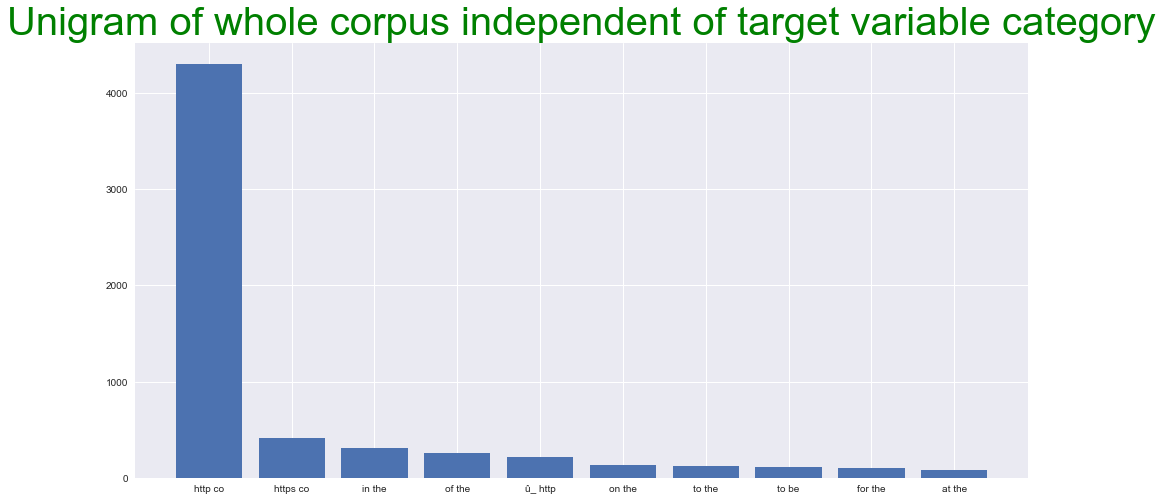

In [124]:
x, y = zip(*top_text_bigrams)
plt.figure(1, figsize=(16, 8))
plt.subplot(1, 1, 1)
plt.title(label="Unigram of whole corpus independent of target variable category", 
          loc="center",
          fontsize=40, 
          color="green") 
plt.bar(x, y)

In [125]:
def create_corpus(df, target):
    """
    Create corpus based on the target.
    """
    corpus = []

    for x in df[df["target"] == target].text.str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [126]:
corpus0 = create_corpus(df=train, target=0)
corpus1 = create_corpus(df=train, target=1)

punc0 = defaultdict(int)
for word in corpus0:
    if word in string.punctuation:
        punc0[word] += 1

punc1 = defaultdict(int)
for word in corpus1:
    if word in string.punctuation:
        punc1[word] += 1

<BarContainer object of 10 artists>

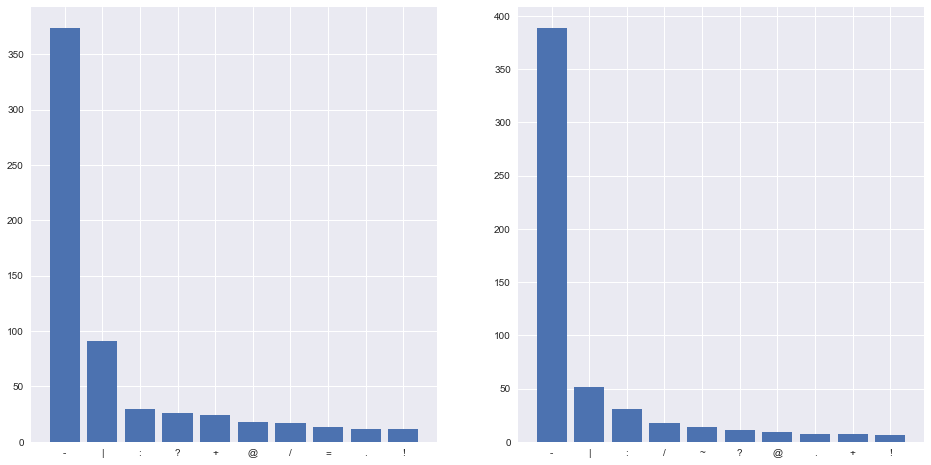

In [127]:
top0 = sorted(punc0.items(), key=lambda x: x[1], reverse=True)[:10]
top1 = sorted(punc1.items(), key=lambda x: x[1], reverse=True)[:10]

x0, y0 = zip(*top0)
x1, y1 = zip(*top1)

plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.bar(x0, y0)
plt.subplot(1, 2, 2)
plt.bar(x1, y1)

we've seen a lot of URLs and HTML elements during our N-gram analysis its time to get ride of them


In [128]:
import re


def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)
def remove_stopwords(text):
    from nltk.corpus import stopwords
    stop = set(stopwords.words("english"))
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

In [129]:
train["text"] = train.text.map(lambda x: remove_URL(x))
train["text"] = train.text.map(lambda x: remove_html(x))
train["text"] = train.text.map(lambda x: remove_emoji(x))
train["text"] = train.text.map(lambda x: remove_punct(x))
train["text"] = train["text"].map(remove_stopwords)

## WordCloud for each of the target class

Text(0.5, 1.0, 'WordCloud for non disasters ')

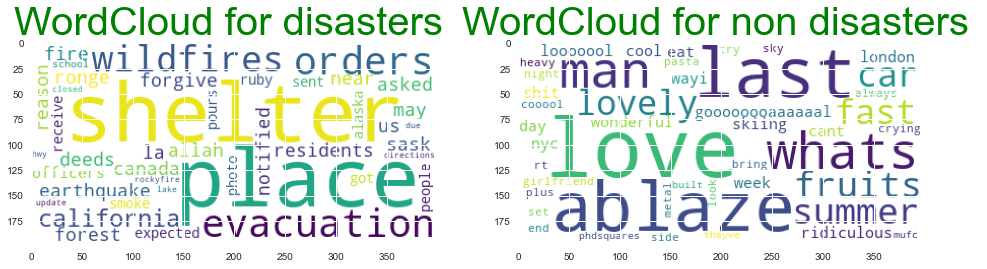

In [130]:
from wordcloud import WordCloud
corpus0 = create_corpus(df=train, target=0)
corpus1 = create_corpus(df=train, target=1)
word_cloud0 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpus0[:50])
)
word_cloud1 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpus1[:50])
)

plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(word_cloud1)
plt.title(label="WordCloud for disasters ", 
          loc="center",
          fontsize=40, 
          color="green")
plt.subplot(1, 2, 2)
plt.imshow(word_cloud0)
plt.title(label="WordCloud for non disasters ", 
          loc="center",
          fontsize=40, 
          color="green")
           

## Performing Stemming

In [131]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()


def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]

    return " ".join(text)

Text(0.5, 1.0, 'WordCloud after stemming for non disasters ')

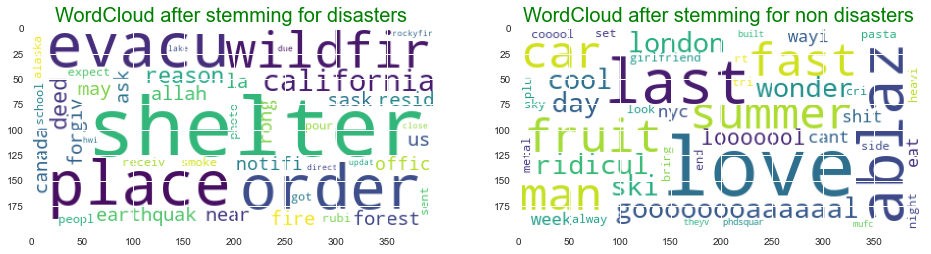

In [132]:
train["text"] = train["text"].map(stemming)
corpus0 = create_corpus(df=train, target=0)
corpus1 = create_corpus(df=train, target=1)

word_cloud0 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpus0[:50])
)
word_cloud1 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpus1[:50])
)

plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(word_cloud1)
plt.title(label="WordCloud after stemming for disasters ", 
          loc="center",
          fontsize=20, 
          color="green")
plt.subplot(1, 2, 2)
plt.imshow(word_cloud0)
plt.title(label="WordCloud after stemming for non disasters ", 
          loc="center",
          fontsize=20, 
          color="green")
           

## Tokenization

In [133]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

train["tokens"] = train["text"].map(tokenizer.tokenize)

In [134]:
train[["text", "tokens"]].head(10)

,text,tokens
0,deed reason earthquak may allah forgiv us,"[deed, reason, earthquak, may, allah, forgiv, us]"
1,forest fire near la rong sask canada,"[forest, fire, near, la, rong, sask, canada]"
2,resid ask shelter place notifi offic evacu she...,"[resid, ask, shelter, place, notifi, offic, ev..."
3,13000 peopl receiv wildfir evacu order california,"[13000, peopl, receiv, wildfir, evacu, order, ..."
4,got sent photo rubi alaska smoke wildfir pour ...,"[got, sent, photo, rubi, alaska, smoke, wildfi..."
5,rockyfir updat california hwi 20 close direct ...,"[rockyfir, updat, california, hwi, 20, close, ..."
6,flood disast heavi rain caus flash flood stree...,"[flood, disast, heavi, rain, caus, flash, floo..."
7,im top hill see fire wood,"[im, top, hill, see, fire, wood]"
8,there emerg evacu happen build across street,"[there, emerg, evacu, happen, build, across, s..."
9,im afraid tornado come area,"[im, afraid, tornado, come, area]"


##                                                    Bag of words

Bag of words embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

In [135]:
from sklearn.feature_extraction.text import CountVectorizer


def count_vect(data, ngrams=(1, 1)):
    count_vectorizer = CountVectorizer(ngram_range=ngrams)
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [136]:
train_counts, count_vectorizer = count_vect(train["text"])
test_counts = count_vectorizer.transform(test["text"])

In [137]:
train.shape

(7613, 6)

In [138]:
train_counts.todense().shape

(7613, 14731)

In [140]:
print(train.text.iloc[0])
print(train_counts.todense()[0][0:].sum())

deed reason earthquak may allah forgiv us
7


## TF IDF


TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer




In [143]:
#with unigram
train_tfidf, tfidf_vectorizer = tfidf(train["text"])
test_tfidf = tfidf_vectorizer.transform(test["text"])
print(train_tfidf.todense()[0][0:].sum())

2.5913673888143647


In [145]:
#with bigram
train_tfidf, tfidf_vectorizer = tfidf(train["text"], ngrams=(1, 2))
test_tfidf = tfidf_vectorizer.transform(test["text"])
print(train_tfidf.todense()[0][0:].sum())

3.5383184674382417


## Visualizing the embeddings

In [146]:
X_counts = train_counts
X_tfidf = train_tfidf
y = train["target"].values

In [147]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ["orange", "blue", "blue"]
    if plot:
        plt.scatter(
            lsa_scores[:, 0],
            lsa_scores[:, 1],
            s=8,
            alpha=0.8,
            c=test_labels,
            cmap=matplotlib.colors.ListedColormap(colors),
        )
        red_patch = mpatches.Patch(color="orange", label="Irrelevant")
        green_patch = mpatches.Patch(color="blue", label="Disaster")
        plt.legend(handles=[red_patch, green_patch], prop={"size": 16})


Text(0.5, 1.0, 'TF-IDF ')

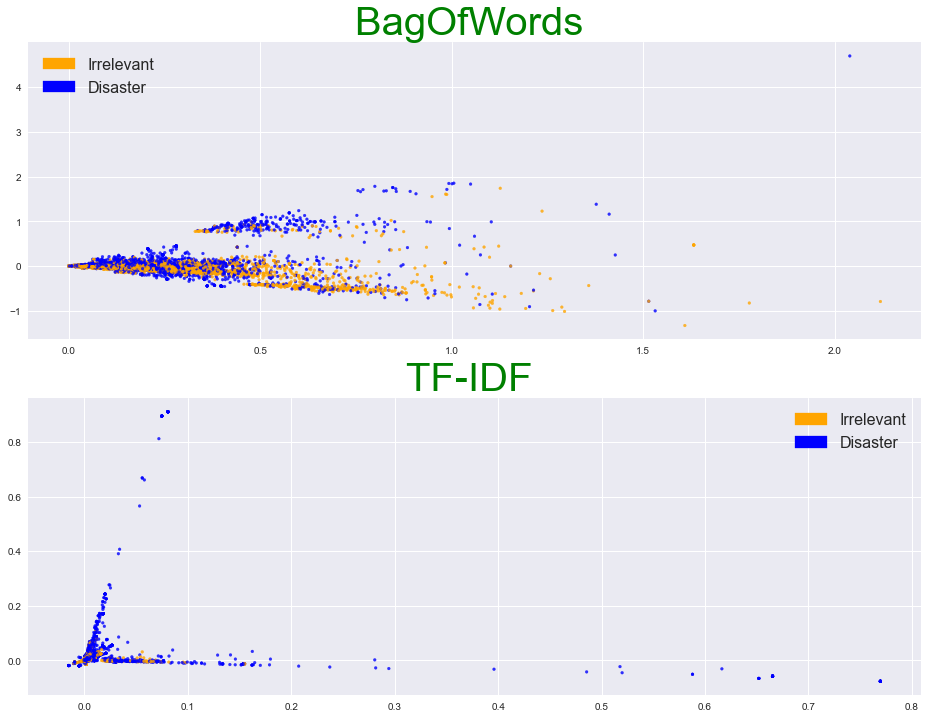

In [149]:
plt.figure(1, figsize=(16, 12))
plt.subplot(2, 1, 1)
plot_LSA(X_counts, y)
plt.title(label="BagOfWords ", 
          loc="center",
          fontsize=40, 
          color="green")
plt.subplot(2, 1, 2)
plot_LSA(X_tfidf, y)
plt.title(label="TF-IDF ", 
          loc="center",
          fontsize=40, 
          color="green")

## Logistic Regression

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

with Bag-of-words model

In [152]:
X = train_counts
y = train["target"].values

X_train_counts, X_test, y_train_counts, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_counts, y_train_counts)

y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred)
print(f"Counts Model Score: {f1score * 100} %")

Counts Model Score: 77.03125 %


with TF-IDF model

In [153]:
X = train_tfidf
y = train["target"].values

X_train_tfidf, X_test, y_train_tfidf, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_tfidf, y_train_tfidf)
y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred)
print(f"Tfidf Model Score: {f1score * 100} %")

Tfidf Model Score: 76.38436482084691 %


In [155]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   tokens    7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


##  Embedding and LSTM Recurrent Neural Network

	BOW model and TF-IDF model are not good for complicated tasks cause they can't understand the context of words but Word Embedding incorporate the context and meaning of words on top of that the dimensionality is reduced  in case of word embeddings 


In [156]:
from collections import Counter

# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [157]:
text = train.text

counter = counter_word(text)

In [165]:
num_words = len(counter)
# Max number of words in a sequence
max_length = 20

In [ ]:
print(len(counter))
print(counter)

Train / test split

In [166]:
train_size = int(train.shape[0] * 0.8)

train_sentences = train.text[:train_size]
train_labels = train.target[:train_size]

test_sentences = train.text[train_size:]
test_labels = train.target[train_size:]

In [167]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

In [168]:
word_index = tokenizer.word_index

In [170]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

In [ ]:
word_index

In [171]:
train_sequences[0]

[3344, 487, 283, 77, 1277, 2610, 21]

In [172]:
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)

In [173]:
train_padded[0]

array([3344,  487,  283,   77, 1277, 2610,   21,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [174]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)

In [175]:
print(train.text[0])
print(train_sequences[0])

deed reason earthquak may allah forgiv us
[3344, 487, 283, 77, 1277, 2610, 21]


Check inverse

In [177]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [178]:
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

In [179]:
decode(train_sequences[0])

'deed reason earthquak may allah forgiv us'

In [180]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(num_words, 32, input_length=max_length))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))


optimizer = Adam(learning_rate=3e-4)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [181]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            478560    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 503,457
Trainable params: 503,457
Non-trainable params: 0
_________________________________________________________________


In [182]:
model = model.fit(
    train_padded, train_labels, epochs=20, validation_data=(test_padded, test_labels),
)


Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 5s 801us/step - loss: 0.6437 - accuracy: 0.6238 - val_loss: 0.5197 - val_accuracy: 0.7663
Epoch 2/20
6090/6090 [==============================] - 4s 682us/step - loss: 0.3921 - accuracy: 0.8286 - val_loss: 0.5138 - val_accuracy: 0.7663
Epoch 3/20
6090/6090 [==============================] - 4s 681us/step - loss: 0.2694 - accuracy: 0.8972 - val_loss: 0.5590 - val_accuracy: 0.7603
Epoch 4/20
6090/6090 [==============================] - 4s 680us/step - loss: 0.1855 - accuracy: 0.9371 - val_loss: 0.6087 - val_accuracy: 0.7551 0.1863 - accuracy: 
Epoch 5/20
6090/6090 [==============================] - 4s 679us/step - loss: 0.1382 - accuracy: 0.9548 - val_loss: 0.7653 - val_accuracy: 0.7459
Epoch 6/20
6090/6090 [==============================] - 4s 677us/step - loss: 0.1094 - accuracy: 0.9649 - val_loss: 0.8281 - val_accuracy: 0.7170
Epoch 7/20
6090/6090 [==============================] -